# Use of XGBoost algorithm in future loss insurance claim

**This work contains three data sets. 
Dataset 1 has all claims that were found from a Loss History Report at driver level.
DataSet 2 has all information we have from this household’s insurance application (Application date of January 1, 2017)
Dataset 3 has information about subsequent loss-experience of these applicants.
Here we will use the criteria to count a claim is that it must have at least one dollar paid out and be prior to the Application Date January 1, 2017. Use the indicator to know if the claim is an At Fault loss or Not At Fault loss.**

# Lets import some basic Python libraries and given datasets.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
#Lets set up the No of Column display such that all the data can be seen.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Load the Claim Dateset

In [4]:
#Lets bring in first dataset (Claim dataset)
claim=pd.read_excel('Data1.xlsm')
claim.head()

,hhld_id,clm_dates,aft_ind,pd_amt
0,6599,2010-12-09,1,5736.39
1,1454,2010-06-14,1,3257.49
2,13691,2011-01-08,1,8190.45
3,10347,2014-02-09,0,428.48
4,6051,2010-03-31,0,107.57


In [6]:
#Exploring the data properties of the features
print(claim.shape)
print(claim.dtypes)
print(claim.describe())

(5000, 4)
hhld_id               int64
clm_dates    datetime64[ns]
aft_ind               int64
pd_amt              float64
dtype: object
            hhld_id      aft_ind        pd_amt
count   5000.000000  5000.000000   5000.000000
mean   10002.493000     0.304800   2444.760016
std     5791.111778     0.460369   3694.201778
min        2.000000     0.000000      0.000000
25%     5081.500000     0.000000    189.830000
50%     9937.000000     0.000000    293.065000
75%    15009.500000     1.000000   5042.352500
max    19997.000000     1.000000  19405.070000


In [7]:
#It is important to check if any claim date is same as application date, that can be used to separate the data.
(claim['clm_dates']=='2017-01-01').sum()

0

In [8]:
#checking if there is any null values in the data
claim.isnull().sum()

hhld_id      0
clm_dates    0
aft_ind      0
pd_amt       0
dtype: int64

**This shows that there is no null Values and there is no claims filed on application date.**

In [9]:
#lets set the Application date to January 1, 2017 and convert it into datetime64 format
from datetime import datetime 
App_dt = pd.DataFrame({'date': ['2017-01-01']})
App_dt=App_dt.astype('datetime64')
print(App_dt)
App_dt.dtypes

        date
0 2017-01-01


date    datetime64[ns]
dtype: object

In [10]:
#Finding the newest and oldest date
print(claim.clm_dates.max())
print(claim.clm_dates.min())

2017-10-10 00:00:00
2010-01-01 00:00:00


**Before we aggregrate the columns, lets explore the conditions that satisfy the criteria as explained in problem statements. The criteria to count a claim is that it must have at least one dollar paid out and be prior to the Application Date of January 1, 2017**

In [11]:
#Finding how many of the claims were paid less than a Dollar
claim.loc[claim.pd_amt <= 1, 'pd_amt'].count()

108

In [12]:
# Finding the households that have a claim prior to January 1, 2017 (Application Date) and 
#the Claims that has been paid at least 1 Dollar.
claim_counts=claim[(claim.clm_dates <='2017-01-01')  & (claim.pd_amt >= 1)]
claim_counts.shape

(4888, 4)

**Now we want to use the data to find at fault or not fault for the last 5 years from the Application Date and aggregate the records.**

In [13]:
#Aggregate by household ID count this shows that some household has repeated counts meaning multiple claims were filed
cnt_hhld_id=claim_counts.groupby(['hhld_id']).count()
cnt_hhld_id.shape

(4297, 3)

In [14]:
#Now lets find the claims that were filed only for the last five years from the Application date of January 1 2017
claim_counts_5y=claim_counts[(claim_counts.clm_dates >='2012-01-01')]
print(claim_counts_5y.shape)
print(claim_counts_5y.clm_dates.max())
print(claim_counts_5y.clm_dates.min())
claim_counts_5y.head()

(3529, 4)
2016-12-30 00:00:00
2012-01-01 00:00:00


,hhld_id,clm_dates,aft_ind,pd_amt
3,10347,2014-02-09,0,428.48
6,2388,2016-08-01,1,2092.55
8,8845,2015-08-10,1,6133.88
11,14318,2015-11-26,0,157.36
12,13283,2012-04-28,0,164.90


**Now lets aggregate the claim data based on household column counts and create two new columns of data separated by: one at fault and one not at fault.**

In [15]:
#Use groupby function to group the claims by household Ids and unstack function to separate them out using at fault index.
hhld_grp=claim_counts_5y.groupby(by=['hhld_id'])['aft_ind'].value_counts().unstack().fillna(0)
print(hhld_grp.shape)
hhld_grp.head()

(3218, 2)


aft_ind,0,1
hhld_id,,
2,1.0,0.0
13,0.0,1.0
27,1.0,0.0
36,1.0,0.0
49,1.0,0.0


In [16]:
#lets rename columns, reset Index and create a column that counts total of the claims for each households
claim_data=hhld_grp.rename(columns={0: "Not_At_Fault", 1: "At_Fault"})
claim_data=claim_data.reset_index()
claim_data['Loss_total']=claim_data['Not_At_Fault']+claim_data['At_Fault']
claim_data.head()

aft_ind,hhld_id,Not_At_Fault,At_Fault,Loss_total
0,2,1.0,0.0,1.0
1,13,0.0,1.0,1.0
2,27,1.0,0.0,1.0
3,36,1.0,0.0,1.0
4,49,1.0,0.0,1.0


In [18]:
#explore the claim data further 
claim_df=claim_data[['hhld_id','At_Fault','Not_At_Fault']]
print(claim_df.info())
print(claim_df.describe())
claim_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3218 entries, 0 to 3217
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hhld_id       3218 non-null   int64  
 1   At_Fault      3218 non-null   float64
 2   Not_At_Fault  3218 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 75.5 KB
None
aft_ind       hhld_id     At_Fault  Not_At_Fault
count     3218.000000  3218.000000   3218.000000
mean     10017.544438     0.332505      0.764139
std       5771.081929     0.486760      0.534766
min          2.000000     0.000000      0.000000
25%       5105.500000     0.000000      0.000000
50%       9962.000000     0.000000      1.000000
75%      14915.750000     1.000000      1.000000
max      19997.000000     3.000000      3.000000


aft_ind,hhld_id,At_Fault,Not_At_Fault
0,2,0.0,1.0
1,13,1.0,0.0
2,27,0.0,1.0
3,36,0.0,1.0
4,49,0.0,1.0


**Now the first set of data is ready.**

# Read in second data set and do Exploratory Data Analysis 

In [19]:
#Lets bring in second dataset
Predictor=pd.read_excel('Data2.xlsm')
Predictor.head()

,hhld_id,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,hoh_married,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,curnt_insurer,time_w_carr,inforce_ind,prior_bi,fire_ind,homeowner_ind,veh_lien_cnt,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,zipcode
0,15937,2,1,43.789978,51.366176,51.366176,47.578077,333.479735,424.394117,424.394117,378.936926,0,2,0,1,1,True,1,0,0.0,0,0,0.0,0,PROGRESSIVE,3.0,1,25000.0,0,0,0.0,0,0,0,1,1,1,100,100,825.949106,35741
1,13778,1,1,35.644631,35.644631,35.644631,35.644631,235.735566,235.735566,235.735566,235.735566,0,0,1,0,1,False,1,0,0.0,0,0,0.0,0,OTHER,1.5,1,25000.0,1,1,NaN,0,0,0,1,1,0,25,25,684.650216,87884
2,16063,1,1,16.000000,16.000000,16.000000,16.000000,0.000000,0.000000,0.000000,0.000000,1,1,0,0,1,False,1,0,0.0,0,2,2.0,0,FARMERS,5.0,1,50000.0,0,1,NaN,0,0,0,1,1,1,100,100,596.318289,81525
3,12789,1,1,17.882127,17.882127,17.882127,17.882127,22.585530,22.585530,22.585530,22.585530,1,1,0,0,1,False,1,0,0.0,0,0,0.0,0,OTHER,0.0,1,100000.0,1,0,NaN,0,0,1,1,1,1,100,100,636.757859,35741
4,5122,1,1,16.000000,16.000000,16.000000,16.000000,0.000000,0.000000,0.000000,0.000000,1,0,1,0,1,False,1,0,0.0,0,0,0.0,0,OTHER,2.5,1,25000.0,0,0,NaN,0,0,0,0,1,1,50,50,669.569992,59792


In [20]:
#Look into predictor dataset and do EDA
print(Predictor.shape)
Predictor.dtypes

(20000, 41)


hhld_id              int64
drvr_cnt             int64
veh_cnt              int64
min_age            float64
hoh_age            float64
max_age            float64
avg_age            float64
min_mon_lic        float64
hoh_mon_lic        float64
max_mon_lic        float64
avg_mon_lic        float64
cnt_yth              int64
cnt_female           int64
cnt_male             int64
cnt_married          int64
cnt_single           int64
hoh_married           bool
cnt_auto             int64
cnt_mtrcyc           int64
avg_majr_viol      float64
cnt_majr_viol        int64
cnt_minr_viol        int64
avg_minr_viol      float64
cnt_lic_susp         int64
curnt_insurer       object
time_w_carr        float64
inforce_ind          int64
prior_bi           float64
fire_ind             int64
homeowner_ind        int64
veh_lien_cnt       float64
veh_lease_cnt        int64
veh_own_cnt          int64
monthly_pay_ind      int64
veh_w_coll_cnt       int64
veh_w_comp_cnt       int64
veh_w_ers_cnt        int64
c

In [21]:
#lets see how many unique variables are there for the categorical columns and boolean columns
print(Predictor['curnt_insurer'].describe())
Predictor['hoh_married'].describe()

count       20000
unique          9
top       MISSING
freq         7010
Name: curnt_insurer, dtype: object


count     20000
unique        2
top       False
freq      10791
Name: hoh_married, dtype: object

**There is only one categorical variable, which is 'curnt_insurer' (Name of current insurer). There is also one boolean column namely 'hoh_married'(Indicator if head of household is married).These two columns will be encoded using dummy variable encoding technique. lets feature engineer these columns.**

In [22]:
#Now lets convert these categorical features to numerical values using dummies.
Predictor_fe=pd.get_dummies(Predictor,columns= ['curnt_insurer','hoh_married']).astype(float)
print(Predictor_fe.shape)
Predictor_fe.head()

(20000, 50)


,hhld_id,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,time_w_carr,inforce_ind,prior_bi,fire_ind,homeowner_ind,veh_lien_cnt,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,zipcode,curnt_insurer_ALLSTATE,curnt_insurer_AMERICAN FAMILY,curnt_insurer_FARMERS,curnt_insurer_GEICO,curnt_insurer_LIBERTY MUTUAL,curnt_insurer_MISSING,curnt_insurer_NATIONWIDE,curnt_insurer_OTHER,curnt_insurer_PROGRESSIVE,hoh_married_False,hoh_married_True
0,15937.0,2.0,1.0,43.789978,51.366176,51.366176,47.578077,333.479735,424.394117,424.394117,378.936926,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,100.0,100.0,825.949106,35741.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,13778.0,1.0,1.0,35.644631,35.644631,35.644631,35.644631,235.735566,235.735566,235.735566,235.735566,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,1.0,25000.0,1.0,1.0,NaN,0.0,0.0,0.0,1.0,1.0,0.0,25.0,25.0,684.650216,87884.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,16063.0,1.0,1.0,16.000000,16.000000,16.000000,16.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,5.0,1.0,50000.0,0.0,1.0,NaN,0.0,0.0,0.0,1.0,1.0,1.0,100.0,100.0,596.318289,81525.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,12789.0,1.0,1.0,17.882127,17.882127,17.882127,17.882127,22.585530,22.585530,22.585530,22.585530,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,100000.0,1.0,0.0,NaN,0.0,0.0,1.0,1.0,1.0,1.0,100.0,100.0,636.757859,35741.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,5122.0,1.0,1.0,16.000000,16.000000,16.000000,16.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,1.0,25000.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,1.0,1.0,50.0,50.0,669.569992,59792.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


**Lets check for the Null values and its prercentage in the second dataset.**

In [23]:
# Lets find missing data percentage in descending order 
total = Predictor_fe.isnull().sum().sort_values(ascending=False)
percent_1 = Predictor_fe.isnull().sum()/Predictor_fe.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head()

,Total,%
veh_lien_cnt,19974,99.9
time_w_carr,7010,35.0
prior_bi,7010,35.0
credit_score,921,4.6
cnt_female,0,0.0


**Based on above information the three categories 'Number of vehicles liened in household', 'Bodily Injury Coverage Individual Limit with current insurer' and 'Time with current insurer' are missing more than 35% of the data. These variables do not seem to be significant for modeling assuming they are not direct bearer of person may have accident and subsequent claim in future (our dependent variable that we are tryting to model), I will drop these columns. The 'credit_score' columns has less than 5% null values, so I will impute that later.**

In [24]:
#dropping columns that has more that 35% missing values
Predictor_cln=Predictor_fe.loc[:, Predictor_fe.isnull().mean()< 0.35]
print(Predictor_cln.shape)

(20000, 47)


In [26]:
# Now impute the credit score columns using Median method
Predictor_cln['credit_score']=Predictor_cln['credit_score'].fillna(Predictor_cln['credit_score'].median())
print(Predictor_cln['credit_score'].describe())

count    20000.000000
mean       663.689902
std         99.031551
min        300.000000
25%        598.997337
50%        664.601282
75%        731.725106
max        850.000000
Name: credit_score, dtype: float64


<ipython-input-26-419f4b629b4f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Predictor_cln['credit_score']=Predictor_cln['credit_score'].fillna(Predictor_cln['credit_score'].median())


In [27]:
#Now check for Null values in the data one more times
Na_Predictor_cln = pd.concat([Predictor_cln.isnull().sum()], axis=1)
Na_Predictor_cln[Na_Predictor_cln.sum(axis=1) > 0]

,0


**This means the second dataset does not have any null values and all the columns are numerical and ready to go.**

# Reading and exploring the third dataset

In [29]:
#Lets bring in third dataset (Loss Experience Data)
LossExpr=pd.read_excel('Data3.xlsm')
LossExpr.head()

,hhld_id,premium,pd_amt,loss_ratio,future_clm_ind
0,15937,133.6,0.0,0.0,0
1,13778,145.8,0.0,0.0,0
2,16063,167.0,0.0,0.0,0
3,12789,150.3,0.0,0.0,0
4,5122,117.0,0.0,0.0,0


In [30]:
print(LossExpr.shape)

(20000, 5)


In [31]:
#Checking types and info 
print(LossExpr.dtypes)
LossExpr.describe()

hhld_id             int64
premium           float64
pd_amt            float64
loss_ratio        float64
future_clm_ind      int64
dtype: object


,hhld_id,premium,pd_amt,loss_ratio,future_clm_ind
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,167.744261,48.715658,0.309725,0.043450
std,5773.647028,72.947044,243.910059,1.639705,0.203873
min,1.000000,72.000000,0.000000,0.000000,0.000000
25%,5000.750000,120.240000,0.000000,0.000000,0.000000
50%,10000.500000,150.300000,0.000000,0.000000,0.000000
75%,15000.250000,180.000000,0.000000,0.000000,0.000000
max,20000.000000,608.000000,2873.556000,25.051470,1.000000


In [32]:
#check for missing values here
Na_lossExpr = pd.concat([LossExpr.isnull().sum()], axis=1)
Na_lossExpr[Na_lossExpr.sum(axis=1) > 0]

,0


**This data set looks good and ready to go.**

# 2. Now lets Merge  Data2 & Data3 and the agrgregated data from data1 using Household ID column as common index.

In [33]:
#Merge Data 2 andData 3 first
mrg_df=pd.merge(Predictor_cln, LossExpr, on='hhld_id', how='left')
print(mrg_df.shape)
mrg_df.head()

(20000, 51)


,hhld_id,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,inforce_ind,fire_ind,homeowner_ind,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,zipcode,curnt_insurer_ALLSTATE,curnt_insurer_AMERICAN FAMILY,curnt_insurer_FARMERS,curnt_insurer_GEICO,curnt_insurer_LIBERTY MUTUAL,curnt_insurer_MISSING,curnt_insurer_NATIONWIDE,curnt_insurer_OTHER,curnt_insurer_PROGRESSIVE,hoh_married_False,hoh_married_True,premium,pd_amt,loss_ratio,future_clm_ind
0,15937.0,2.0,1.0,43.789978,51.366176,51.366176,47.578077,333.479735,424.394117,424.394117,378.936926,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,100.0,100.0,825.949106,35741.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,133.6,0.0,0.0,0
1,13778.0,1.0,1.0,35.644631,35.644631,35.644631,35.644631,235.735566,235.735566,235.735566,235.735566,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,25.0,25.0,684.650216,87884.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,145.8,0.0,0.0,0
2,16063.0,1.0,1.0,16.000000,16.000000,16.000000,16.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,100.0,100.0,596.318289,81525.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,167.0,0.0,0.0,0
3,12789.0,1.0,1.0,17.882127,17.882127,17.882127,17.882127,22.585530,22.585530,22.585530,22.585530,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,100.0,100.0,636.757859,35741.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,150.3,0.0,0.0,0
4,5122.0,1.0,1.0,16.000000,16.000000,16.000000,16.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,50.0,50.0,669.569992,59792.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,117.0,0.0,0.0,0


**Now lets merge aggregated Claim data with the other two data sets based on Household IDs.**

In [34]:
#merge engineered data 1 with merged data 2 and data 3
df_final=pd.merge(mrg_df,claim_df, on='hhld_id', how='left')
print(df_final.shape)
df_final.head()

(20000, 53)


,hhld_id,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,inforce_ind,fire_ind,homeowner_ind,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,zipcode,curnt_insurer_ALLSTATE,curnt_insurer_AMERICAN FAMILY,curnt_insurer_FARMERS,curnt_insurer_GEICO,curnt_insurer_LIBERTY MUTUAL,curnt_insurer_MISSING,curnt_insurer_NATIONWIDE,curnt_insurer_OTHER,curnt_insurer_PROGRESSIVE,hoh_married_False,hoh_married_True,premium,pd_amt,loss_ratio,future_clm_ind,At_Fault,Not_At_Fault
0,15937.0,2.0,1.0,43.789978,51.366176,51.366176,47.578077,333.479735,424.394117,424.394117,378.936926,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,100.0,100.0,825.949106,35741.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,133.6,0.0,0.0,0,1.0,1.0
1,13778.0,1.0,1.0,35.644631,35.644631,35.644631,35.644631,235.735566,235.735566,235.735566,235.735566,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,25.0,25.0,684.650216,87884.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,145.8,0.0,0.0,0,NaN,NaN
2,16063.0,1.0,1.0,16.000000,16.000000,16.000000,16.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,100.0,100.0,596.318289,81525.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,167.0,0.0,0.0,0,NaN,NaN
3,12789.0,1.0,1.0,17.882127,17.882127,17.882127,17.882127,22.585530,22.585530,22.585530,22.585530,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,100.0,100.0,636.757859,35741.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,150.3,0.0,0.0,0,NaN,NaN
4,5122.0,1.0,1.0,16.000000,16.000000,16.000000,16.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,50.0,50.0,669.569992,59792.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,117.0,0.0,0.0,0,NaN,NaN


**Now I want to find what percentage of data is missing on these At Fault and Not at Fault columns.**

In [35]:
#finding percentage of missing data after merging them all
no_claim_data = df_final.isnull().sum().sort_values(ascending=False)
percent_1 = df_final.isnull().sum()/df_final.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([no_claim_data, percent_2], axis=1, keys=['no_claim_data', '%'])
missing_data.head()

,no_claim_data,%
Not_At_Fault,16782,83.9
At_Fault,16782,83.9
drvr_cnt,0,0.0
cnt_married,0,0.0
fire_ind,0,0.0


**Here the percentage of missing data which is ~84%. Eventhough, these two columns can be imputed for missing values,this is way above the threshold where data imputation would make a significant impact in modeling. So I will drop all the rows that are missing the values.**

In [36]:
#Drop rows based on NAN values from At Fault and Not At Fault columns and future prediction counts.
df=df_final.dropna()
print(df.shape)
df.head()

(3218, 53)


,hhld_id,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,inforce_ind,fire_ind,homeowner_ind,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,zipcode,curnt_insurer_ALLSTATE,curnt_insurer_AMERICAN FAMILY,curnt_insurer_FARMERS,curnt_insurer_GEICO,curnt_insurer_LIBERTY MUTUAL,curnt_insurer_MISSING,curnt_insurer_NATIONWIDE,curnt_insurer_OTHER,curnt_insurer_PROGRESSIVE,hoh_married_False,hoh_married_True,premium,pd_amt,loss_ratio,future_clm_ind,At_Fault,Not_At_Fault
0,15937.0,2.0,1.0,43.789978,51.366176,51.366176,47.578077,333.479735,424.394117,424.394117,378.936926,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,100.0,100.0,825.949106,35741.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,133.60,0.000000,0.000000,0,1.0,1.0
10,11886.0,4.0,3.0,19.318661,43.789978,43.789978,37.672149,39.823932,333.479735,333.479735,260.065785,0.0,2.0,2.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,25.0,25.0,413.262688,16107.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,384.00,0.000000,0.000000,0,0.0,1.0
14,9155.0,2.0,2.0,25.277394,42.306708,42.306708,33.792051,111.328723,315.680500,315.680500,213.504611,0.0,0.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,2.0,1.0,100.0,100.0,612.255960,85767.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,278.10,1353.605481,4.867334,1,0.0,1.0
30,5768.0,1.0,1.0,47.566353,47.566353,47.566353,47.566353,378.796232,378.796232,378.796232,378.796232,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,250.0,250.0,710.243668,57609.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,120.24,0.000000,0.000000,0,1.0,0.0
42,6706.0,1.0,1.0,30.366404,30.366404,30.366404,30.366404,172.396849,172.396849,172.396849,172.396849,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,25.0,25.0,687.903987,83031.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,150.30,0.000000,0.000000,0,1.0,0.0


# Now lets do more feature engineering of this data and make it ready for modeling

In [37]:
print(df.shape)
df.head()

(3218, 53)


,hhld_id,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,avg_mon_lic,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,cnt_auto,cnt_mtrcyc,avg_majr_viol,cnt_majr_viol,cnt_minr_viol,avg_minr_viol,cnt_lic_susp,inforce_ind,fire_ind,homeowner_ind,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,zipcode,curnt_insurer_ALLSTATE,curnt_insurer_AMERICAN FAMILY,curnt_insurer_FARMERS,curnt_insurer_GEICO,curnt_insurer_LIBERTY MUTUAL,curnt_insurer_MISSING,curnt_insurer_NATIONWIDE,curnt_insurer_OTHER,curnt_insurer_PROGRESSIVE,hoh_married_False,hoh_married_True,premium,pd_amt,loss_ratio,future_clm_ind,At_Fault,Not_At_Fault
0,15937.0,2.0,1.0,43.789978,51.366176,51.366176,47.578077,333.479735,424.394117,424.394117,378.936926,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,100.0,100.0,825.949106,35741.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,133.60,0.000000,0.000000,0,1.0,1.0
10,11886.0,4.0,3.0,19.318661,43.789978,43.789978,37.672149,39.823932,333.479735,333.479735,260.065785,0.0,2.0,2.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,25.0,25.0,413.262688,16107.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,384.00,0.000000,0.000000,0,0.0,1.0
14,9155.0,2.0,2.0,25.277394,42.306708,42.306708,33.792051,111.328723,315.680500,315.680500,213.504611,0.0,0.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,2.0,1.0,100.0,100.0,612.255960,85767.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,278.10,1353.605481,4.867334,1,0.0,1.0
30,5768.0,1.0,1.0,47.566353,47.566353,47.566353,47.566353,378.796232,378.796232,378.796232,378.796232,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,250.0,250.0,710.243668,57609.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,120.24,0.000000,0.000000,0,1.0,0.0
42,6706.0,1.0,1.0,30.366404,30.366404,30.366404,30.366404,172.396849,172.396849,172.396849,172.396849,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,25.0,25.0,687.903987,83031.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,150.30,0.000000,0.000000,0,1.0,0.0


**first lets separate the predicted column named 'future_clm_ind' as our dependent y variable.**


In [38]:
#separete the dependent variable
y=df[['future_clm_ind']]
y.shape

(3218, 1)

**Here first thing I want to see is if the data class is balanced or not based on the future loss prediction.**

C:\Users\MK\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


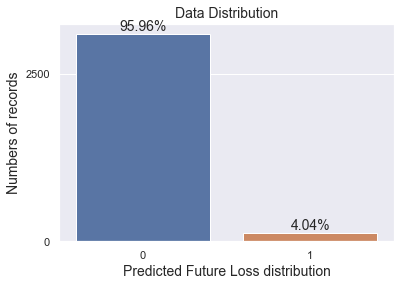

In [39]:
# Graphical representation of the target label percentage.
total_len = len(y['future_clm_ind'])
sns.set()
sns.countplot(y['future_clm_ind']).set_title('Data Distribution',fontsize=14)
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 2,
            '{:.2f}%'.format(100*(height/total_len)),
            fontsize=14, ha='center', va='bottom')
sns.set(font_scale=5)
ax.set_xlabel("Predicted Future Loss distribution",fontsize=14)
ax.set_ylabel("Numbers of records",fontsize=14)
plt.show()

**This shows that the predicted class is highly imbalanced. While running model in this kind of data, we will have problem with spurious prediction. We may achieve higher accuracy but that may be the result of the class imbalance.**

**Now lets work with the independent features.**

In [40]:
#Separating the X features
df_X=df.drop('future_clm_ind',1)
df_X.shape

(3218, 52)

**Now, lets check for the columns that may have unique values.**

In [466]:
#check for Unique values
nunique = df_X.nunique()
nunique

hhld_id                          3218
drvr_cnt                            4
veh_cnt                             4
min_age                          3041
hoh_age                          3127
max_age                          3125
avg_age                          3133
min_mon_lic                      3035
hoh_mon_lic                      3117
max_mon_lic                      3115
avg_mon_lic                      3123
cnt_yth                             3
cnt_female                          5
cnt_male                            5
cnt_married                         5
cnt_single                          5
cnt_auto                            5
cnt_mtrcyc                          4
avg_majr_viol                       9
cnt_majr_viol                       6
cnt_minr_viol                       6
avg_minr_viol                      12
cnt_lic_susp                        2
inforce_ind                         2
fire_ind                            2
homeowner_ind                       2
veh_lease_cn

**This shows there is no features with unique values.**

**Next main thing is to check if there are colinearity and multi colinearity in this data. I will test a variety of methods here to remove a possible bias in the training set.**

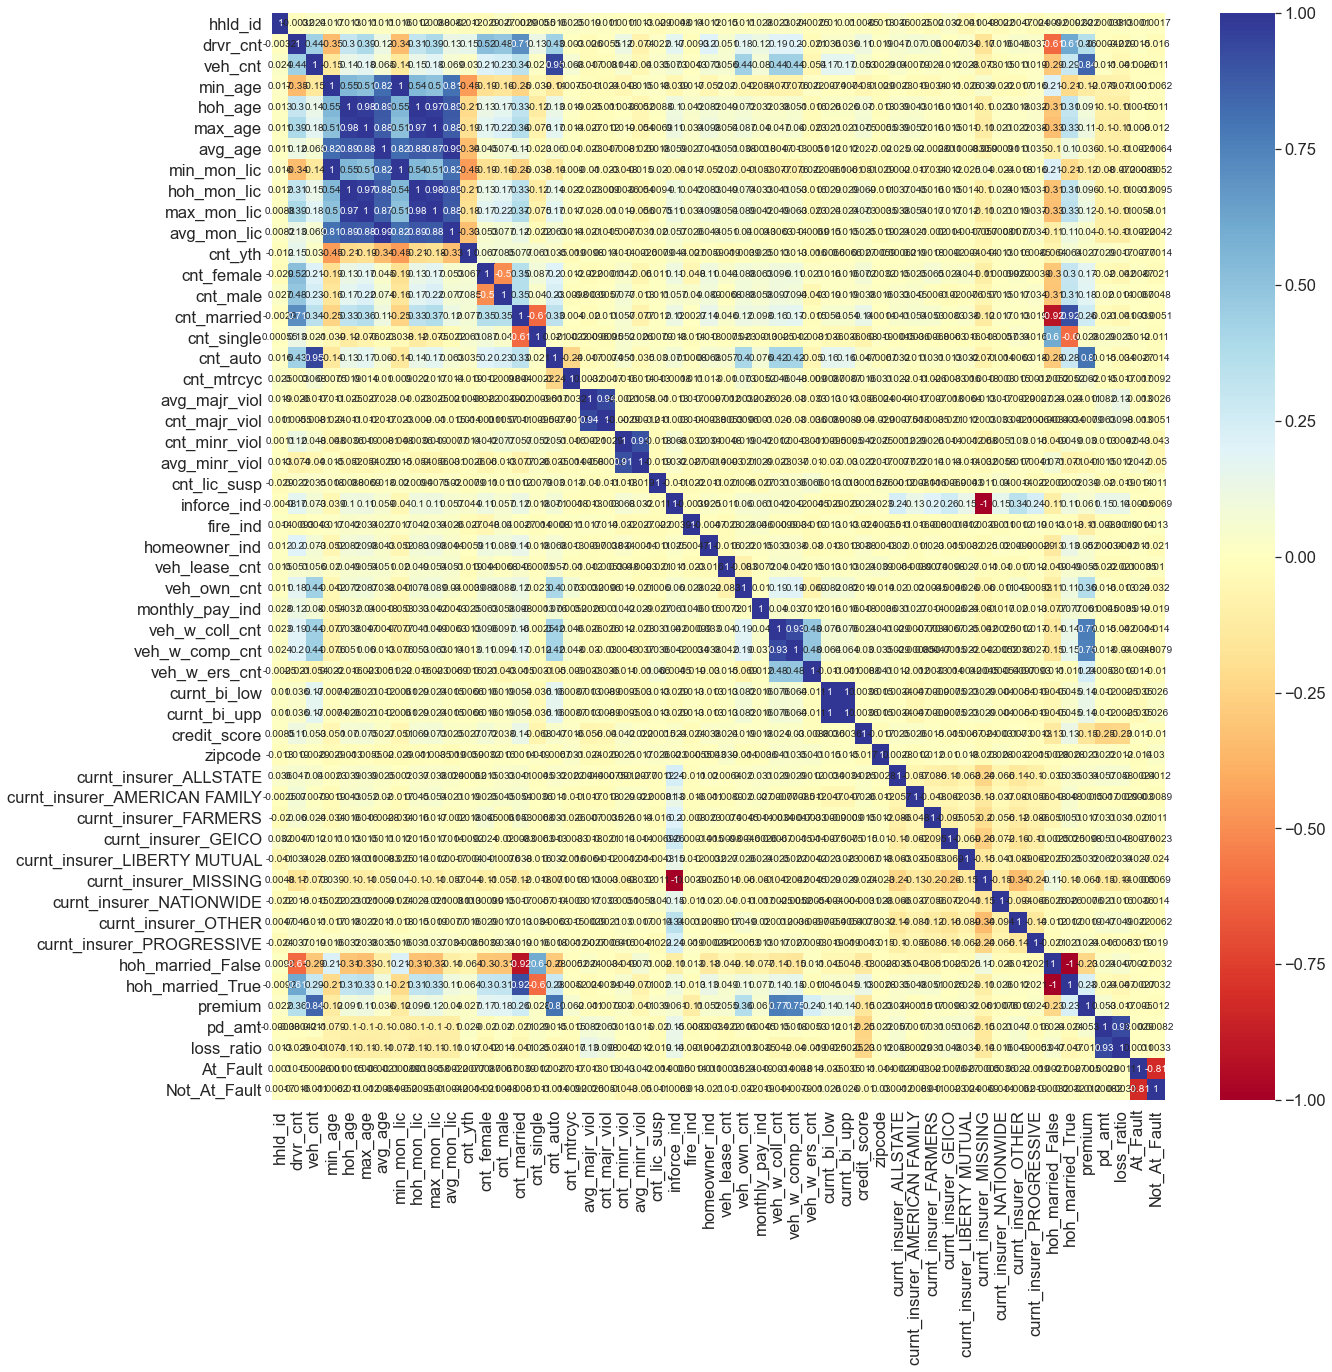

In [41]:
# First lets look on sns heat map
import matplotlib.pyplot as plt 
X=df_X.iloc[:] 
y=y[:]
corrmat = X.corr() 
top_corr_features = corrmat.index 
plt.figure(figsize=(20,20)) 
#plot heat map 
sns.set(font_scale=1.5) 
graph=sns.heatmap(df_X[top_corr_features].corr(),annot=True,annot_kws={'size': 10}, cmap="RdYlBu")

**Based on the plot above, for the pairs that have correlation values close to Plus/Minus 1 (higher than plus/minus 0.9), I will dropped one of the two features.**

In [42]:
df_X_dropped=df_X.drop(columns=['curnt_insurer_MISSING','hoh_married_False',
                                    'hoh_married_True','cnt_auto'])
df_X_dropped.shape

(3218, 48)

**lets also check for the correlation coefficient with more than 0.8 correlation and drop them.**

In [43]:
# lets check with simple person correlation and see if any columns are highly correlated threshold of 80%

def correlation(df_X_dropped, threshold):
    col_corr=set()
    corr_matrix=df_X_dropped.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>threshold:
                colname=corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr
corr_features=correlation(df_X_dropped, 0.8)
#len(set(corr_features))
corr_features

{'Not_At_Fault',
 'avg_age',
 'avg_minr_viol',
 'avg_mon_lic',
 'cnt_majr_viol',
 'curnt_bi_upp',
 'hoh_mon_lic',
 'loss_ratio',
 'max_age',
 'max_mon_lic',
 'min_mon_lic',
 'premium',
 'veh_w_comp_cnt'}

In [44]:
#dropping columns with more than 80% corelation
df_X_dropped_2=df_X_dropped.drop(columns=['Not_At_Fault','avg_age','avg_minr_viol','avg_mon_lic',
                                           'cnt_majr_viol','curnt_bi_upp','hoh_mon_lic','loss_ratio',
                                            'max_age','max_mon_lic','min_mon_lic','premium','veh_w_comp_cnt'])

In [45]:
print(df_X_dropped_2.shape)
df_X_dropped_2.head()

(3218, 35)


,hhld_id,drvr_cnt,veh_cnt,min_age,hoh_age,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,cnt_mtrcyc,avg_majr_viol,cnt_minr_viol,cnt_lic_susp,inforce_ind,fire_ind,homeowner_ind,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_ers_cnt,curnt_bi_low,credit_score,zipcode,curnt_insurer_ALLSTATE,curnt_insurer_AMERICAN FAMILY,curnt_insurer_FARMERS,curnt_insurer_GEICO,curnt_insurer_LIBERTY MUTUAL,curnt_insurer_NATIONWIDE,curnt_insurer_OTHER,curnt_insurer_PROGRESSIVE,pd_amt,At_Fault
0,15937.0,2.0,1.0,43.789978,51.366176,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,100.0,825.949106,35741.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1.0
10,11886.0,4.0,3.0,19.318661,43.789978,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,25.0,413.262688,16107.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
14,9155.0,2.0,2.0,25.277394,42.306708,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,1.0,100.0,612.255960,85767.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1353.605481,0.0
30,5768.0,1.0,1.0,47.566353,47.566353,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,250.0,710.243668,57609.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.0
42,6706.0,1.0,1.0,30.366404,30.366404,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,25.0,687.903987,83031.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,1.0


In [47]:
# I will do one more test for multi-colinearlity and see what stands out.
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif =pd.DataFrame()
vif['Variance inflation factor'] = [variance_inflation_factor(df_X_dropped_2.values, i) for i in range(df_X_dropped_2.shape[1])]
vif['feature_names'] = df_X_dropped_2.columns

In [48]:
#Normally we use  VIF of 10 as threshold to remove features in a dataset. But in this data since we dont 
#know what most of these feature really means (having infinity) and I have already filles null values with interative and frequency 
#so I am going to use a higher value of 10

high_vif_col = vif[vif['Variance inflation factor']>=10]
print(high_vif_col)

    Variance inflation factor                  feature_names
1                         inf                       drvr_cnt
2                   10.272868                        veh_cnt
3                   21.961755                        min_age
4                   29.185334                        hoh_age
6                         inf                     cnt_female
7                         inf                       cnt_male
8                         inf                    cnt_married
9                         inf                     cnt_single
14                        inf                    inforce_ind
23                  22.451084                   credit_score
25                        inf         curnt_insurer_ALLSTATE
26                        inf  curnt_insurer_AMERICAN FAMILY
27                        inf          curnt_insurer_FARMERS
28                        inf            curnt_insurer_GEICO
29                        inf   curnt_insurer_LIBERTY MUTUAL
30                      

**Since this data has many values with 1 and 0, the calculation of variance produced infinity that does necessarily mean anything. So for now I will only remove the features that has VIF greater than 10 but not those that has infinity.**

In [50]:
#removing features with VIF >10.
df_X_dropped_3=df_X_dropped_2.drop(columns=['veh_cnt','min_age','hoh_age','credit_score'])
print(df_X_dropped_3.shape)
df_X_dropped_3.head()

(3218, 31)


,hhld_id,drvr_cnt,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,cnt_mtrcyc,avg_majr_viol,cnt_minr_viol,cnt_lic_susp,inforce_ind,fire_ind,homeowner_ind,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_ers_cnt,curnt_bi_low,zipcode,curnt_insurer_ALLSTATE,curnt_insurer_AMERICAN FAMILY,curnt_insurer_FARMERS,curnt_insurer_GEICO,curnt_insurer_LIBERTY MUTUAL,curnt_insurer_NATIONWIDE,curnt_insurer_OTHER,curnt_insurer_PROGRESSIVE,pd_amt,At_Fault
0,15937.0,2.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,100.0,35741.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1.0
10,11886.0,4.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,25.0,16107.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
14,9155.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,1.0,100.0,85767.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1353.605481,0.0
30,5768.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,250.0,57609.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.0
42,6706.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,25.0,83031.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,1.0


**Here data is almost ready to run a first base model. I am going to run a base Logistic Regrssion model for classification process and look at some feature importance. To do this I want to apply standard scaler to the data. Here I will copy the data and use scaled data for base model and regular(unscaled) data for final model.**

In [51]:
#this will be used for standard scaler and logistic regression base model
df_lr=df_X_dropped_3
df_lr.shape

(3218, 31)

**Since I will run the logistic regression as my base model, I will use standard scaler method to scale the features that will go to the base model to remove the data range sensitivity.**

In [53]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
df_lr[df_lr.columns]=sc.fit_transform(df_lr[df_lr.columns])
print(df_lr.shape)
df_lr.head()

(3218, 31)


,hhld_id,drvr_cnt,cnt_yth,cnt_female,cnt_male,cnt_married,cnt_single,cnt_mtrcyc,avg_majr_viol,cnt_minr_viol,cnt_lic_susp,inforce_ind,fire_ind,homeowner_ind,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_ers_cnt,curnt_bi_low,zipcode,curnt_insurer_ALLSTATE,curnt_insurer_AMERICAN FAMILY,curnt_insurer_FARMERS,curnt_insurer_GEICO,curnt_insurer_LIBERTY MUTUAL,curnt_insurer_NATIONWIDE,curnt_insurer_OTHER,curnt_insurer_PROGRESSIVE,pd_amt,At_Fault
0,1.025869,0.666897,-0.282623,1.705133,-1.078670,0.277730,0.355468,-0.163284,-0.096343,-0.444852,-0.103336,0.748746,-0.810063,-0.934986,-0.204355,-0.712629,-0.64527,0.207692,0.332308,0.570848,-0.750892,-0.317685,-0.17816,-0.270892,-0.349897,-0.196811,-0.206818,-0.454532,3.153661,-0.193895,1.371517
10,0.323812,3.498130,-0.282623,1.705133,1.790057,1.406184,1.935434,-0.163284,-0.096343,-0.444852,-0.103336,0.748746,-0.810063,1.069535,-0.204355,-0.712629,-0.64527,1.822071,-1.740107,-0.659553,-1.496524,3.147773,-0.17816,-0.270892,-0.349897,-0.196811,-0.206818,-0.454532,-0.317092,-0.193895,-0.683204
14,-0.149483,0.666897,-0.282623,-1.083036,1.790057,1.406184,-1.224498,-0.163284,-0.096343,-0.444852,-0.103336,0.748746,1.234472,-0.934986,-0.204355,2.561090,-0.64527,1.822071,0.332308,0.570848,1.148926,3.147773,-0.17816,-0.270892,-0.349897,-0.196811,-0.206818,-0.454532,-0.317092,5.543549,-0.683204
30,-0.736466,-0.748720,-0.282623,0.311048,-1.078670,-0.850724,0.355468,-0.163284,-0.096343,-0.444852,-0.103336,0.748746,1.234472,-0.934986,-0.204355,-0.712629,-0.64527,0.207692,0.332308,3.031652,0.079581,-0.317685,-0.17816,-0.270892,2.857987,-0.196811,-0.206818,-0.454532,-0.317092,-0.193895,1.371517
42,-0.573906,-0.748720,-0.282623,0.311048,-1.078670,-0.850724,0.355468,4.747450,-0.096343,-0.444852,-0.103336,0.748746,1.234472,1.069535,-0.204355,0.924231,-0.64527,0.207692,0.332308,-0.659553,1.045022,-0.317685,-0.17816,-0.270892,-0.349897,5.081010,-0.206818,-0.454532,-0.317092,-0.193895,1.371517


# Lets split the data into train and test sets before running more test for feature importance


In [54]:
#lets import machine learning libraries
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [55]:
#Define X and y
X=df_lr
y=df['future_clm_ind']
X.shape,y.shape

((3218, 31), (3218,))

In [56]:
#splitting the data
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.shape)


(2574, 31)
(644, 31)
(644,)
(2574,)


# Create a base model using logistic regression and then based on their coefficinet score find the most importance features.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       618
           1       1.00      1.00      1.00        26

    accuracy                           1.00       644
   macro avg       1.00      1.00      1.00       644
weighted avg       1.00      1.00      1.00       644

[[618   0]
 [  0  26]]
Accuracy  ::  1.0
AUC:  1.0


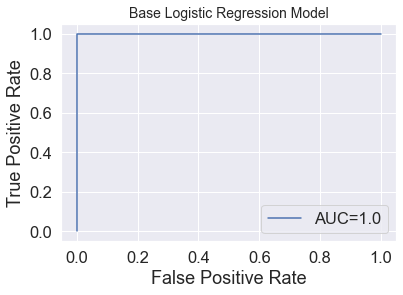

In [57]:
#Create a base logistic Regression model
base_model = LogisticRegression()

# Fit our data
base_model.fit(X_train, y_train)

expected = y_test
prediction = base_model.predict(X_test)

# summarize the fit of the model
print(metrics.classification_report(expected, prediction))
print(metrics.confusion_matrix(expected, prediction))

print ("Accuracy  :: ", accuracy_score(expected, prediction))

acc_base_model= round(base_model.score(X_train, y_train) * 100, 4)

# Finding AUC Score for this model
base_model_probs=base_model.predict_proba(X_test)[::,1]
print('AUC: ', roc_auc_score(y_test, base_model_probs))

fpr, tpr, _ = metrics.roc_curve(y_test,  base_model_probs)
auc = metrics.roc_auc_score(y_test, base_model_probs)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Base Logistic Regression Model', fontsize=14)
plt.legend(loc=4)
plt.show()


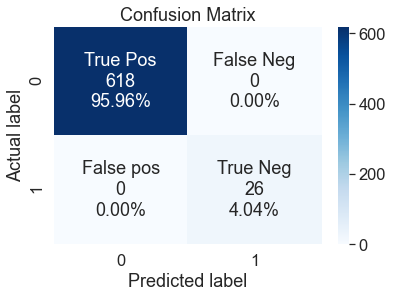

In [58]:
#Now lets Plot the confusion Matrix
ax= plt.subplot()
cf_matrix = metrics.confusion_matrix(y_test,prediction)

group_names = ['True Pos','False Neg','False pos','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

**The model shows AUC of 1. This could be misleading because of imbalanced class and possible multi-colinearity bias.So lets first look at feature importance based on the coefficient of each features.**

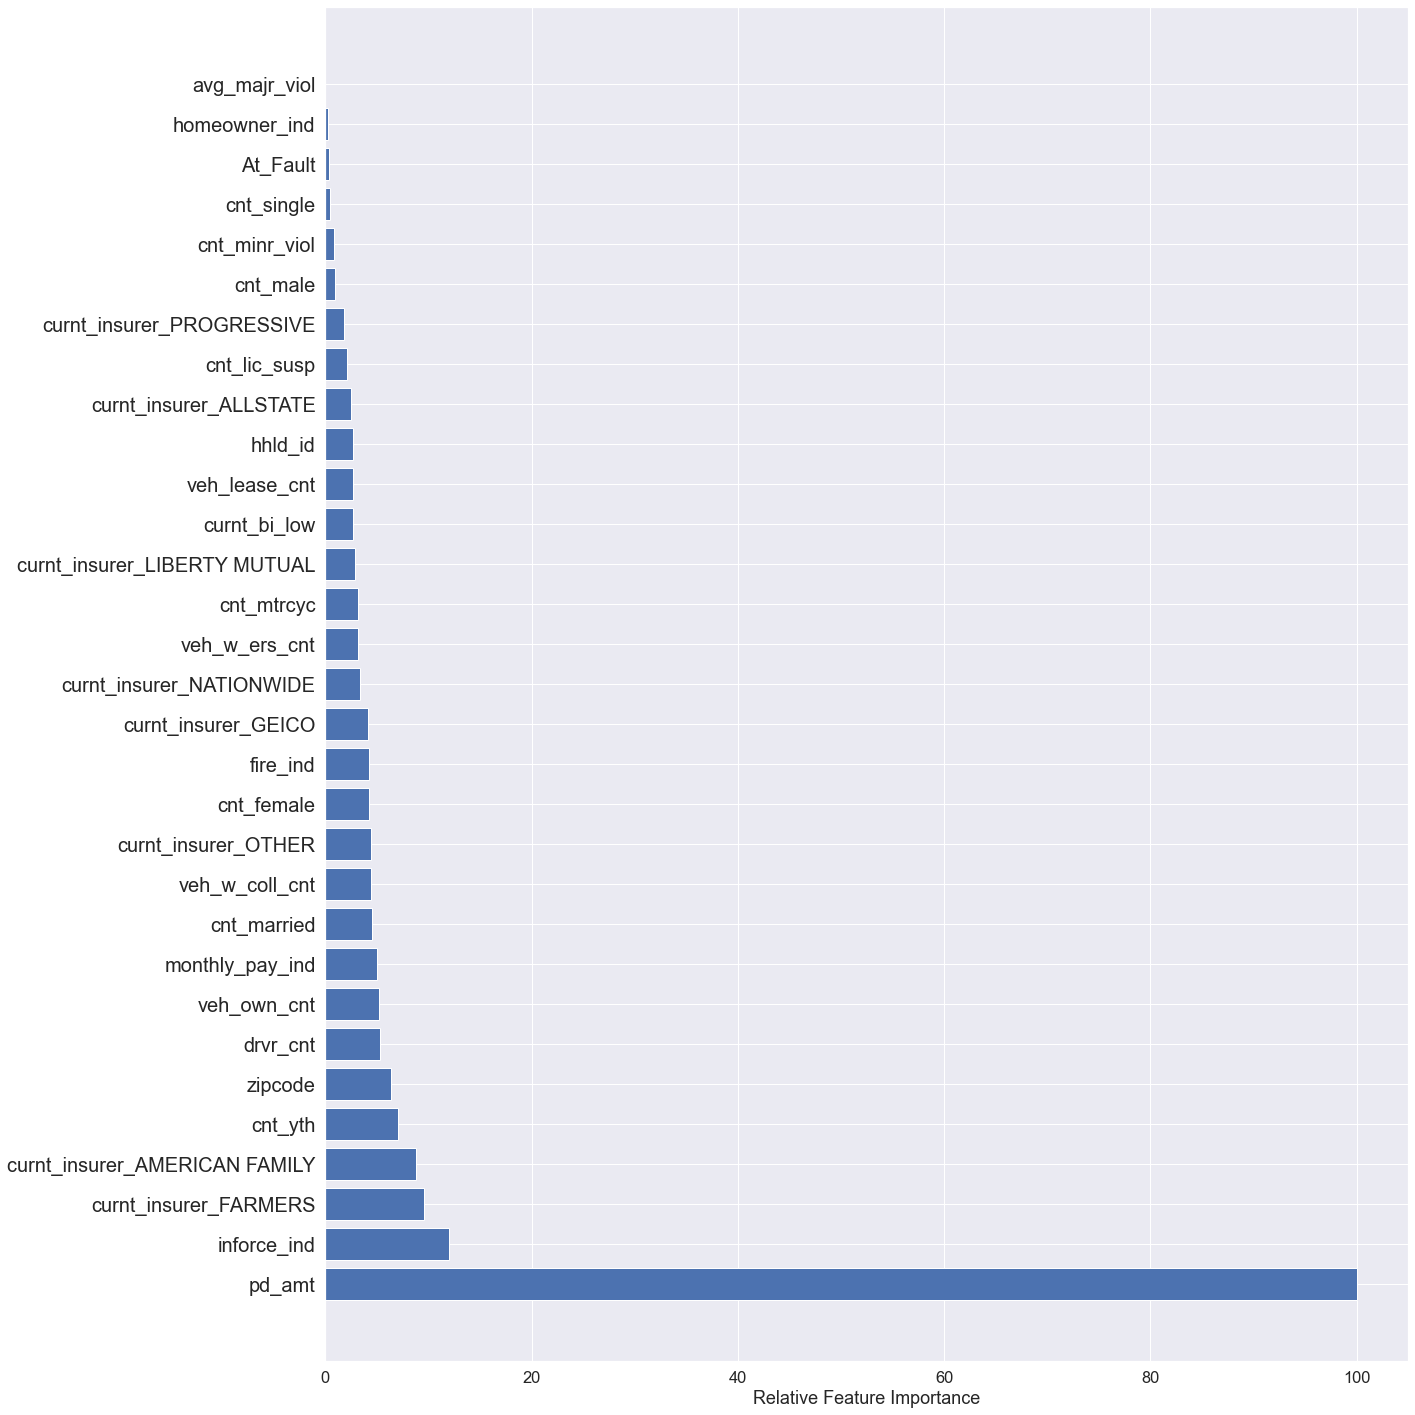

In [59]:
#Finding the most important features based on base model feature coefficients
feature_importance = abs(base_model.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[::-1][:]
pos = np.arange(sorted_idx.shape[0]) + .5
featfig = plt.figure(figsize=(20,20))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=20)
featax.set_xlabel('Relative Feature Importance')
plt.tight_layout()   
plt.show()

In [60]:
feature_imp = pd.Series(abs(base_model.coef_[0]),index=X_train.columns).sort_values(ascending=False)
print(feature_imp)

pd_amt                           3.821446
inforce_ind                      0.457487
curnt_insurer_FARMERS            0.366786
curnt_insurer_AMERICAN FAMILY    0.335687
cnt_yth                          0.269215
zipcode                          0.242622
drvr_cnt                         0.203148
veh_own_cnt                      0.200191
monthly_pay_ind                  0.190567
cnt_married                      0.175188
veh_w_coll_cnt                   0.170476
curnt_insurer_OTHER              0.170288
cnt_female                       0.163861
fire_ind                         0.162838
curnt_insurer_GEICO              0.159949
curnt_insurer_NATIONWIDE         0.128550
veh_w_ers_cnt                    0.122497
cnt_mtrcyc                       0.121325
curnt_insurer_LIBERTY MUTUAL     0.110533
curnt_bi_low                     0.104084
veh_lease_cnt                    0.103521
hhld_id                          0.103100
curnt_insurer_ALLSTATE           0.096937
cnt_lic_susp                     0

**Now lets find top 10 important features and rerun the model with applying class balance using SMOTE technique.**

In [61]:
#lets make a feature importance with reduced set 
importances = abs(base_model.coef_[0])
importances_top10= np.argsort(importances)[::-1][0:10]
important_feature_index = [i for i in importances_top10]
important_features_to_model = X_train.iloc[:, important_feature_index]
reducedSet = important_features_to_model.columns
print(reducedSet)

Index(['pd_amt', 'inforce_ind', 'curnt_insurer_FARMERS',
       'curnt_insurer_AMERICAN FAMILY', 'cnt_yth', 'zipcode', 'drvr_cnt',
       'veh_own_cnt', 'monthly_pay_ind', 'cnt_married'],
      dtype='object')


In [62]:
X_train_r = X_train[reducedSet]
X_test_r = X_test[reducedSet]
X_test_r.shape,X_train_r.shape

((644, 10), (2574, 10))

**As we know the predicted class is highly imbalanced, the results is baised toward the positive class giving us false accuracy values. So we will apply Synthetic Minority Oversampling Technique (SMOTE) to balance this data.**

In [63]:
# Data balancing applied using SMOTE process
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from collections import Counter
#print('Original dataset shape {}'.format(Counter(y_train)))
smt = SMOTE(sampling_strategy=0.5, k_neighbors=10, random_state=20)
X_sm, y_sm = smt.fit_resample(X_train_r, y_train)
#print('New dataset shape {}'.format(Counter(y_sm)))
X_sm = pd.DataFrame(X_sm, columns = list(X_train_r.columns))
X_sm = preprocessing.scale(X_sm)
X_sm = pd.DataFrame(X_sm, columns = list(X_train_r.columns))
#print(y_sm.value_counts())
#print(X_sm.shape)
#print(y_sm.shape)

# Run final logistic regression model with 10 important features and Synthetic Minority Oversampling Technique(SMOTE) applied data to balance the imbalance class prediction.

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       618
           1       0.67      1.00      0.80        26

    accuracy                           0.98       644
   macro avg       0.83      0.99      0.89       644
weighted avg       0.99      0.98      0.98       644

[[605  13]
 [  0  26]]
Accuracy  ::  0.9798136645962733
AUC:  0.9999999999999999


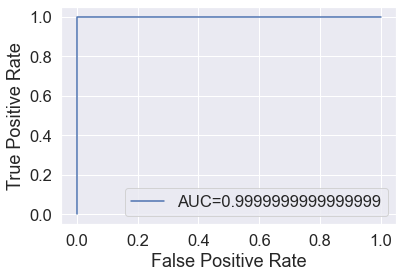

In [64]:
# Create LogisticRegression model
log_model_sm = LogisticRegression()

# Fit our data
log_model_sm.fit(X_sm, y_sm)

expected = y_test
prediction_sm = log_model_sm.predict(X_test_r)

# summarize the fit of the model
print(metrics.classification_report(expected, prediction_sm))
print(metrics.confusion_matrix(expected, prediction_sm))

print ("Accuracy  :: ", accuracy_score(expected, prediction_sm))

acc_log_model_sm = round(log_model_sm.score(X_sm, y_sm) * 100, 2)

# Finding AUC Score for this model
log_model_sm_probs=log_model_sm.predict_proba(X_test_r)[::,1]
print('AUC: ', roc_auc_score(y_test, log_model_sm_probs))

fpr, tpr, _ = metrics.roc_curve(y_test,  log_model_sm_probs)
auc = metrics.roc_auc_score(y_test, log_model_sm_probs)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

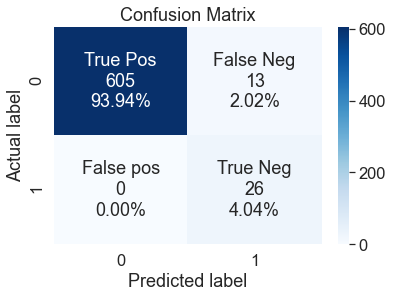

In [65]:
#Now lets Plot the confusion Matrix
ax= plt.subplot()
cf_matrix = metrics.confusion_matrix(y_test,prediction_sm)

group_names = ['True Pos','False Neg','False pos','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

**Based on this result, we can see that only about 2% of the result is showing a False Negative class. This model is giving me accuracy of 97% with the ROC AUC of 1.**

# Now I will use 10 most important features selected by base model and run a XGboost model, where I will use hyper parameter tuning techniques and also the k fold cross validation techniques to make sure my model is prediction is better and balanced.


**XGboost model can help with imbalanced class when proper weighting factor for positive class is applied. But we dont want to use scaled data for the XGboost model because scaling is not required for decision tree based models. So here I am going to use the dataset before we scaled it. I will first run the hyper parameter tunning in the model and then fit the model.**

In [66]:
df_xgb=df_X_dropped_3[['pd_amt', 'inforce_ind', 'curnt_insurer_FARMERS','curnt_insurer_AMERICAN FAMILY', 
                  'cnt_yth', 'zipcode', 'drvr_cnt', 'veh_own_cnt', 'monthly_pay_ind', 'cnt_married']]
df_xgb.shape

(3218, 10)

In [67]:
#Define X and y
X1=df_xgb
y1=df['future_clm_ind']
X1.shape,y1.shape

((3218, 10), (3218,))

In [68]:
#Now lets do split of this data to run XGBoost
#splitting the data
X1_train,X1_test,y1_train,y1_test=train_test_split(X1,y, test_size=0.2, stratify=y, random_state=42)
print(X1_train.shape)
print(X1_test.shape)
print(y1_test.shape)
print(y1_train.shape)

(2574, 10)
(644, 10)
(644,)
(2574,)


In [69]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost
xgboost.XGBClassifier()

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)

**Now lets do some Hyper-parameter Tuning and Optimization based on Randomized search method.**

In [70]:
#  create a params set to do some Hyper Parameter Optimization

params={
 "learning_rate"    : [0.01, 0.05, 0.10, 0.125, 0.15, 0.20 ],
 "max_depth"        : [2, 3, 4, 6, 8, 10],
 "n_estimators"     : [50, 100, 150, 200, 300, 500],
 "min_child_weight" : [1, 3, 5, 7, 9, 11],
 "gamma"            : [0.0, 0.1, 0.2 , 0.3, 0.5, 1.0 ],
 "scale_pos_weight" : [50, 70, 90, 95, 100, 110],
 "colsample_bytree" : [0.1, 0.3, 0.4, 0.5 , 0.7, 0.9]
}

In [71]:
#set timer to see how long it takes to run these hyperparameter tests at once
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        t, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (t, tmin, round(tsec, 2)))

In [72]:
#running random search using RandomizedSearchCV
clf_final=xgboost.XGBClassifier()
random_search=RandomizedSearchCV(clf_final,param_distributions=params,n_iter=50,scoring='roc_auc',n_jobs=-1,cv=5,verbose=1)

In [73]:
#Running optimal pameter search using timer. This will help to estimate the time taken for hyper parameter tuning.
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X1_train,y1_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[14:46:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 17.05 seconds.


C:\Users\MK\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [74]:
#check for xgboost estimator
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, gamma=0.1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=70,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [75]:
#here is our optimized parameters based on training data
random_search.best_params_

{'scale_pos_weight': 70,
 'n_estimators': 150,
 'min_child_weight': 1,
 'max_depth': 2,
 'learning_rate': 0.1,
 'gamma': 0.1,
 'colsample_bytree': 0.7}

In [76]:
classifier=xgboost.XGBClassifier(objective='binary:logistic',base_score=0.5, booster='gbtree', 
              colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, gamma=1.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=150, n_jobs=1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=70,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [77]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(classifier,X1_train,y1_train,cv=5)

C:\Users\MK\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\MK\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:47:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:47:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\MK\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\MK\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:47:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:47:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:47:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\MK\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [78]:
score

array([1., 1., 1., 1., 1.])

In [79]:
score.mean()

1.0

# Now its time to run the final model with optimized parameters.

[0]	validation_0-auc:0.61361
[1]	validation_0-auc:1.00000
[2]	validation_0-auc:1.00000
[3]	validation_0-auc:1.00000
[4]	validation_0-auc:1.00000
[5]	validation_0-auc:1.00000
[6]	validation_0-auc:1.00000
[7]	validation_0-auc:1.00000
[8]	validation_0-auc:1.00000
[9]	validation_0-auc:1.00000
[10]	validation_0-auc:1.00000


C:\Users\MK\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       618
           1       1.00      0.96      0.98        26

    accuracy                           1.00       644
   macro avg       1.00      0.98      0.99       644
weighted avg       1.00      1.00      1.00       644

[[618   0]
 [  1  25]]
Accuracy  ::  0.9984472049689441
AUC:  1.0


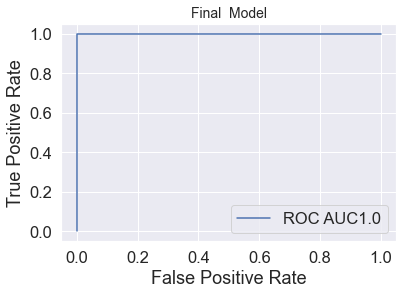

In [86]:
#set up final model parameter
XGB_model=xgboost.XGBClassifier(learning_rate=0.2,
                                scale_pos_weight=70,
                                max_depth=4,
                                n_estimators=150,
                                gamma=1.0,
                                colsample_bytree=0.7,
                                min_child_weight=1,
                                eval_metric='auc',
                               verbosity=1)

#fit the model 
eval_set=[(X1_test,y1_test)]
XGB_model.fit(X1_train,y1_train, early_stopping_rounds=10,eval_set=eval_set, verbose=True)

#Validate model in test data
expected = y1_test
prediction_xgb =XGB_model.predict(X1_test)

# evaluate predictions using metrics

# summarize the fit of the model
print(metrics.classification_report(expected, prediction_xgb))
print(metrics.confusion_matrix(expected, prediction_xgb))

print ("Accuracy  :: ", accuracy_score(expected, prediction_xgb))
acc_XGB_model = round(XGB_model.score(X1_test,y1_test) * 100, 2)

# Finding AUC Score for this model and plotting a ROC AUC curve
XGB_model=XGB_model.predict_proba(X1_test)[::,1]
print('AUC: ', roc_auc_score(y1_test, XGB_model))

fpr, tpr, _ = metrics.roc_curve(y1_test,  XGB_model)
auc = metrics.roc_auc_score(y1_test, XGB_model)

#create ROC curve
plt.plot(fpr,tpr,label="ROC AUC"+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Final  Model', fontsize=14)
plt.legend(loc=4)
plt.show()

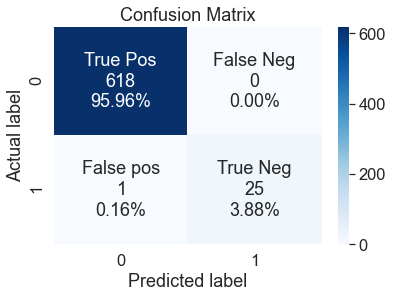

In [87]:
#Now lets Plot the confusion Matrix
ax= plt.subplot()
cf_matrix = metrics.confusion_matrix(y1_test,prediction_xgb)

group_names = ['True Pos','False Neg','False pos','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

# This is my final model where my metric measures are showing great results with Accuracy of 98% for positive class with ROC AUC of 1. I only have 1 False positive case and 0 False negative case. 


# THANK YOU!!